# Scarping House price Details from Trulia  and Data Analysis 

### 1. Data Collection: Extracted data from  from Trulia.com https://www.trulia.com/

In [ ]:
# Importing all the required packages 

import time
import pandas as pd
import requests
import re
import numpy as np
from bs4 import BeautifulSoup
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

#selenium packages
from selenium import webdriver
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys

#### ..................................................................Scraping logic starts here............................................................................................................
#### ............................................Defining helper functions to extract and process data from the HTML......................................................

In [ ]:
#Defining all the functions to extract data from specific tags


#Function to get Bed ,Bath and Floor Size details
def getBasicDetails(tempDict,soup):
    try:
        bed =soup.find("li",{"data-testid" :"bed"}).text
        bath=soup.find("li",{"data-testid" :"bath"}).text
        floor=soup.find("li",{"data-testid" :"floor"}).text
        tempDict['Bed']=bed.split()[0]
        tempDict['Bath']=bath.split()[0]
        tempDict['FloorSize']=floor.split()[0].replace(',',"")
    except:
        print("Exception inside getBasicDetails")
        
        

#Function to get City ,ZipCode
def getAddress(tempDict,soup):
    try:
        addressList=[]
        zipCode=[]
        address=soup.find('span',{"data-testid":"home-details-summary-city-state"}).text
        addressList=address.split(",")
        
        #Checking for City
        if(len(addressList)>=1):
            city=addressList[0].replace(" ","")
            tempDict['City']=city
        else:
            tempDict['City']=None
            
        #Checking for zipCode 
        if(len(addressList)>=2):
            zipCode=re.findall('\d+', addressList[1])
            if(len(zipCode)>=1):
                tempDict['ZipCode']=zipCode[0]
            else:
                tempDict['ZipCode']=None 
            
        else:
            tempDict['ZipCode']=None 
    except:
        tempDict['City']=None
        tempDict['ZipCode']=None
        print("exception - getAddress")
        

#Function to get Year Built and Year updated details
def getYearDetails(tempDict,soup,tables):
    try:
        index=getTableIndex(tables,'Property Information')
        if(index!=-1):
            years=tables[index].loc[0]['Property Information']
            index1=years.find("Year Built:")
            index2=years.find("Year Updated:")
            
            #Check if Year updated info is there. Many house listings dont show this information
            if(index2 !=-1):
                year_updated=years[index2 :]
                year_updated=re.findall('\d+', year_updated)[0]
                tempDict['Year_Updated']=year_updated
                year_built=years[index1 :index2 ]
            else:
                tempDict['Year_Updated']=None
                
            year_built=years[index1:]
            year_built=re.findall('\d+', year_built)[0]
            tempDict['Year_Built']=year_built
        #If Property Info tag is not there Assign both the values to None
        else:
            tempDict['Year_Updated']=None
            tempDict['Year_Built']=None
       
    except:
        print("Exception- getYearDetails")
        tempDict['Year_Updated']=None
        tempDict['Year_Built']=None
        

#Function to get Lot size details
def getLotSize(tempDict,soup,tables):
    try:
        #Getting Lot size
        index=getTableIndex(tables,'Lot Information')
        if(index!=-1):
            lotSize=tables[index].loc[0]['Lot Information'].split(":")[1].replace(",","").strip("sqft").strip()
            tempDict['LotSize']=lotSize 
        else:
            tempDict['LotSize']=None 
    except:
        tempDict["LotSize"]=None
        print("Exception-getLotSize")

#Function to get AgentInfo
def getAgentInfo(tempDict,soup,tables):
    try:
        #Getting Agent Info
        index=getTableIndex(tables,'Agent Information') 
        #If Agent Info tab is not present assign to None.Many listings dont have this detail
        if(index!=-1):
            agentInfo=tables[index].loc[0]['Agent Information'].split(":")[1].strip()
            tempDict["AgentInfo"]=agentInfo
        else:
            tempDict["AgentInfo"]=None
    except:
        tempDict["AgentInfo"]=None
        print("Exception - getAgentInfo")
        

#Function to get Property Type details
def getPropertyInfo(tempDict,soup,tables):
    try:
        #Getting PropertType
        index=getTableIndex(tables,'Property Information') 
        propertyType=tables[index].loc[1]['Property Information'].split(":")[1].strip()
        if(propertyType.find("Architecture")==-1):
            tempDict["PropertyType"]=propertyType
        else:
            tempDict["PropertyType"]=propertyType[0:propertyType.find("Architecture")]
    except:
        tempDict["PropertyType"]=None
        print("Exception -getPropertyInfo")
        

#Function get no of schools near the area.
#TODO: require more cleaning and processing
def getSchoolInfo(tempDict,soup):
    try:
        #Getting school Info
        #schoolInfo=soup.find("div",{"data-testid" :"explore-the-area-schoolsTab"}).text
        #tempDict['School'] =schoolInfo
        schoolInfo=soup.find("div",{"data-testid" :"explore-the-area-schoolsTab"})
        schoolInfotext=schoolInfo.get_text("|", strip=True)
        tempDict["School"]=schoolInfotext
    
    except:
        tempDict["School"]=None
        print("Exception-getSchoolInfo")
        
        
#Function to get reviews regarding Crime history        
def getCrimeInfo(tempDict,soup):
    try:
        crimeInfo=soup.find("div",{"data-testid" :"explore-the-area-crimeTab"}).text
        match=(re.search("Crime",crimeInfo))
        if(match is not None ):
            endIndex=match.span()[1]
            crimeInfo=crimeInfo[endIndex:]
        else:
            pass
        tempDict['Crime'] =crimeInfo
            
    except:
        tempDict["Crime"]=None
        print("Exception - getCrimeInfo")
        
#Function to get ameneties in Area

def getAmeneties(tempDict,soup):
    try:
        amenities=soup.find("div",{"data-testid" :"explore-the-area-amenitiesTab"})
        amenitiesText=amenities.get_text("|", strip=True)
        tempDict["Shop&Eat"]=amenitiesText
        
    except:
        tempDict["Shop&Eat"]=None
        
        
#Function to get HOA details        
def getHOAfees(tempDict,soup,tables):
    try:
        index=getTableIndex(tables,'HOA')
        #Many listings dont show HOA tab;so this check is necessary
        if(index!=-1):
            HOAfees=tables[index].loc[0]['HOA']
            if(HOAfees.find(":")!=-1):
                HOAfees= HOAfees.split(":")[1].strip("/monthly").strip(" ").strip("$")
            else:
                pass
            tempDict["HOAfees"]=HOAfees
        else:
            tempDict["HOAfees"]=None
    except:
        tempDict["HOAfees"]=None
        print("Exception - getHOAfees")
        
        
#Function to get Reviews

def getReviews(tempDict,soup):
    try:
        #Triggering event to capture Reviews
        localInfo=soup.find("div",{"data-testid" :"what-locals-say"})
        seeAllEle=localInfo.find("button",{"data-testid" :"toggle-expand"})
        if seeAllEle is not None:
            seeAllEle.click()
            time.sleep(3)
        else:
            pass
        liTabs=localInfo.find_all("li",{"data-testid" :"wls-attribute"})
        reviewList=[]
        for li in liTabs:
            reviewList.append(li.get_text())
            reviewString='|'.join(reviewList)
        tempDict['reviews']=reviewString.strip()
    except:
         tempDict['reviews']=None
        

#Function to get the index of a specific tab(each tab is inside a table tag) in a scraped table
def getTableIndex(tables,propName):
    index=-1
    for i in range(len(tables)):
        if(propName in tables[i].columns):
            index=i
            break
        else:
            pass
    return index      



#### Writing the driver function which will call above defined helper functions

In [ ]:
#Defining One Parent function to call above functions. This will be called for each house listing

def getHouseDetails(driver):
    tables=[]
    page_source = driver.page_source
    soup =  BeautifulSoup(page_source, 'lxml')
    tempDict={}
    
    #Getting Price Deatils of a listing-SOme price shows "Contact for price info"
    try:
        price=soup.find('h3',{"data-testid":"on-market-price-details"}).text.replace(",","").strip("$")
        tempDict["Price"]=price
    except:
        tempDict['Price'] =None
    
    #TODO: will remove Name later. Added for debugging purpose
    name=soup.find("span",{"data-testid" :"home-details-summary-headline"}).text
    tempDict['name']=name
    
     #Triggering event to click SHow More button to get More details about the house
    
    try:
        showAllEle=driver.find_element_by_xpath("//button[@data-testid='structured-amenities-table-see-all-button']")
        if(showAllEle is not None):
            showAllEle.click()
            time.sleep(3)
        else:
            pass
    except:
        print("ShoWAll ELe not found")
                
    
    #Scraping all the tables in the loaded page using pandas 
    tables = pd.read_html(page_source)
    
    #Calling all the above defined functions to get other house Details 
    getBasicDetails(tempDict,soup)
    getAddress(tempDict,soup)
    getYearDetails(tempDict,soup,tables)
    getLotSize(tempDict,soup,tables)
    getAgentInfo(tempDict,soup,tables)
    getHOAfees(tempDict,soup,tables)
    getSchoolInfo(tempDict,soup)
    getCrimeInfo(tempDict,soup)
    getAmeneties(tempDict,soup)
    getPropertyInfo(tempDict,soup,tables)
    return tempDict


    

In [ ]:
#Declaring the dictionary which will contain house details of all the cities. 
#Key of this dictionary will be City Name and values will be the dataFrames containing details of each property.
houseDict={}

####  Defining the Webscraper using Selenium which will automate the scraping process 

In [ ]:


#Settings required to be in incognito mode
options = webdriver.ChromeOptions()
options.add_argument('--incognito')
baseUrl="https://www.trulia.com"

#Instantiating the chromeDriver . Need explicit installation of selenium and Chrome WebDriver
driver = webdriver.Chrome()
driver.get(baseUrl)

time.sleep(5)


#Defining the cities List.Will be using these cities to query the website and get the details
citiesList=["San Jose, CA","Milpitas, CA","Fremont, CA","Hayward, CA","Castro Valley, CA",
            "Berkeley, CA","Oakland, CA","Dublin, CA","San Ramon, CA",
            "Danville, CA","Union City, CA","Palo Alto, CA","Santa Clara, CA",
            "Cupertino, CA","San Mateo, CA","Burlingame, CA","Pleasanton, CA","Newark, CA",
            "Concord, CA","Walnut Creek, CA","Santa Cruz, CA","Half Moon Bay, CA"]


#Defining standard url pattern used in the Trulia website for each listing so that we can click over that <li> tag to get 
#respective House details

url="//li[@data-testid="

#Parent loop tp iterate over cities
try:
    for j in  range(0,len(citiesList)):
        #.....................Searching the Website with each City value. .......................................
        #.....................This loop will search scrape several deatils about several house listings of each city....... .........................................
        city=str(citiesList[j].split(",")[0]).strip().replace(" ","_")
        state=str(citiesList[j].split(",")[1]).strip()
        element=WebDriverWait(driver,10).until(EC.element_to_be_clickable((By.XPATH, "//input[@data-testid='location-search-input']")))
        try:
            element.click()
            element.send_keys(Keys.CONTROL + "a");
            time.sleep(3)
            element.send_keys(Keys.DELETE);
            #Sending the city value here. This action will populate the search bar of the website with the given value
            element.send_keys(citiesList[j])
            #Trigerring the click event on the Search button
            driver.find_element_by_xpath("//div[@data-testid='location-search-button']").click()
            time.sleep(10)
        except:
            print("Exception in getting Search Box")
            driver.get(baseUrl+"/"+state+"/"+city+"/");
            #driver.refresh()
            time.sleep(5)
            
        #For each city this variable will be maintained. It will populate all the house listings for each city
        houseList=[]
        try:
            for i in range(0,21):
                
                testId="srp-home-card-"+str(i)
                #Creating dynamic Url for each listing and usingt this url to find the element to be clicked
                newUrl=url + "\'" + testId + "\'" +"]"
                #time.sleep(5)
                try:
                    tempEle=WebDriverWait(driver,10).until(EC.element_to_be_clickable((By.XPATH,newUrl)))
                    #print(tempEle)
                    tempEle=tempEle.find_element_by_tag_name('a')
                    #Scroll till that elemnt
                    driver.execute_script("return arguments[0].scrollIntoView(true);", tempEle)
                    time.sleep(3)
                    #print(tempEle)
                    tempEle.send_keys(Keys.ENTER);
                    #Switching the reference to the newly opened tab
                    window_after = driver.window_handles[1]
                    driver.switch_to.window(window_after)
                    time.sleep(3)
                except:
                    print("Exception in click")
                    driver.get(baseUrl+"/"+state+"/"+city+"/");
                    time.sleep(5)
                    #print(newUrl)
                    driver.execute_script("return arguments[0].scrollIntoView(true);", tempEle)
                    time.sleep(3)
                    tempEle.send_keys(Keys.ENTER)
                    window_after = driver.window_handles[1]
                    driver.switch_to.window(window_after)
                    time.sleep(3)
                    
                temphouseDict={}
                temphouseDict=getHouseDetails(driver)
                houseList.append(temphouseDict)
                #Closing the new tab and switching back to the parent tab
                driver.close()
                driver.switch_to.window(driver.window_handles[0])
                time.sleep(3)
            #Storing house deatils of each city to a dictionary
            print(len(houseList))
            houseDict[city]=pd.DataFrame(houseList)
            houseDict[city].to_csv(city+".csv",index=False)
            time.sleep(25)
        except Exception:
            print("Exception",Exception.with_traceback())
            driver.quit()  
    driver.quit()

except:
    print("Exception occured",Exception.with_traceback())
    driver.quit()
    
driver.quit()


#### Merging and Writing the collected data to the csv file

In [ ]:

def mergeCityDetails(houseDict):
    housePricedf=pd.concat(list(houseDict.values()),ignore_index=True)
    housePricedf.drop_duplicates(inplace=True)
    housePricedf.reset_index()
    print(housePricedf.shape)
    return housePricedf



In [ ]:
#Calling the above function and writing the dataframe to the csv file
finaldf=mergeCityDetails(houseDict)
finaldf.to_csv("HousePriceDetails.csv",index=False)
print(finaldf.shape)
finaldf.head()


#### .........................................................................................Scraping Logic ends here....................................................................................

### ...........................................Merging and Processing other Attributes starts here.............................................


#### Reading the data We collected from Trulia Website.

In [662]:
# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)
#housedf.head()
finaldf=pd.read_csv("HousePriceDetails.csv")
print("Shape of orginal df" ,finaldf.shape)
finaldf.head()
housedf=finaldf.copy()
housedf.isnull().sum()

Shape of orginal df (461, 16)


Price             1
name              0
Bed              10
Bath             10
FloorSize        10
City              0
ZipCode           0
Year_Updated    325
Year_Built        8
LotSize          46
AgentInfo         7
HOAfees          12
School            0
Crime             0
Shop&Eat          0
PropertyType      6
dtype: int64

#####  Merging attributes like  Median Income,Population Density,Crime Index,Cost of living Index ,CrimeRateIndex etc  for each Zip Code which we collected by scraping the city-data.come website .

In [663]:
#Getting Unique values of zipCode

uniqueZipCodes=housedf['ZipCode'].unique().tolist()

#ZipDetails.csv has all the related data which we created while scraping the city-data.com Website
zipCodedf=pd.read_csv("zipDetails.csv")

#Add new columns to the original dataframe
newcols=zipCodedf.columns.to_list()
newcols.remove("zipCode")
for i in newcols:
    housedf[i]=None

In [664]:
uniqueZipCodes=housedf['ZipCode'].unique().tolist()


In [665]:
#Merge the details

for i in range(0,len(uniqueZipCodes)):
    zipCode=uniqueZipCodes[i]
    if(zipCodedf[zipCodedf['zipCode']==zipCode].size > 0):
        housedf.loc[housedf['ZipCode']==zipCode,newcols]=zipCodedf[zipCodedf['zipCode']==zipCode].iloc[0].to_list()[:-1]

#Manually adding for zip code 94018 as the respective detail is not present in the website
housedf.loc[housedf['ZipCode']==94018,newcols]=zipCodedf[zipCodedf['zipCode']==94019].iloc[0].to_list()[:-1]

####  Merging Crime Details to this datfarame .This information  is also collected from city-data.com website

In [666]:
#CrimeDetailsperCity.csv was created while Scraping the city-data.come website
cityCrimeIndexdf=pd.read_csv("CrimeDetailsperCity.csv")
uniqueCities=housedf['City'].unique().tolist()
#len(uniqueCities)

In [667]:
#Adding new column for crimeIndex
housedf['CrimeIndex']=None
for i in range(0,len(uniqueCities)):
    city=str(uniqueCities[i])
    if(cityCrimeIndexdf[cityCrimeIndexdf['city']==city].size > 0):
        housedf.loc[housedf['City']==city,'CrimeIndex']=cityCrimeIndexdf[cityCrimeIndexdf['city']==city]['crimeIndex'].item()



C:\Users\jhash\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### 2. Data Cleaning 

#### Defining helper functions to clean the data

In [668]:

def getSchoolCount(val):
    val=re.sub(r'[^\d.]+', '', val)
    valList=list(val)
    valList = [int(i) for i in valList]
    return sum(valList)


    

In [669]:
import math
#Lot SIze.converting acres into squareFeet
housedf['LotSize'] = housedf['LotSize'].apply(lambda x: float(x.replace("acre",''))*43560 if str(x).endswith('acre') else re.sub(r'[^\d.]+', '', str(x)))

#Converting School Info
housedf['SchoolCount']=housedf['School'].apply(lambda x:getSchoolCount(x))

#Removing + sign from the values in Price

housedf['Price']=housedf['Price'].apply(lambda x:str(x).replace('+','') if not pd.isnull(x) else None)

#Removing Monthly sign from the values for HOA
housedf['HOAfees']=housedf['HOAfees'].apply(lambda x:str(x).strip('/M'))

#Removing Shop&Eat text from the column values 
housedf['Shop&Eat']=housedf['Shop&Eat'].apply(lambda x:x.strip('Shop & Eat|'))


housedf['PropertyType']=housedf['PropertyType'].apply(lambda x: str(x).strip() if len(str(x))>0 else None)
#Divide Shop&Eat column into 3 differet columns

housedf[['Restaurants','Groceries','Nightlife']] = housedf['Shop&Eat'].apply(lambda x: pd.Series(str(x).split("|")))

for i in ['Restaurants','Groceries','Nightlife']:
    housedf[i]=housedf[i].apply(lambda x: re.sub(r'[^\d]+', '', str(x)))
    housedf[i] = housedf[i].apply(lambda x: x if len(x)>0 else None )

#Get the age of the house
housedf['Age']=housedf['Year_Built'].apply(lambda x:pd.datetime.now().year-float(x) if len(str(x))>0 else None)

#Drop some of the not very useful colums
housedf.drop(columns=['name','School','Shop&Eat','Year_Updated','Year_Built','Crime','Nightlife'],inplace=True)

In [670]:
#Converting  numerical columns to Numeric Type
cat_cols=['City','ZipCode','PropertyType','AgentInfo','HOAfees']
columns=list(housedf.columns)
numeric_cols=set(columns)-set(cat_cols)
int_cols=['Bed','Bath','SchoolCount','Restaurants','Groceries','Age']
float_cols=numeric_cols-set(int_cols)

#Removing commas for all numerical columns
housedf[list(numeric_cols)] = housedf[list(numeric_cols)].replace(',', '', regex=True)
housedf[list(float_cols)] = housedf[list(float_cols)].apply(pd.to_numeric)

#No need to convert every numerical column to float. Explicitly convert some columns to Int
for i in int_cols:
    housedf[i] = housedf[i].astype(int,errors='ignore')
for i in cat_cols:
    housedf[i] = housedf[i].astype(object,errors='ignore')

In [672]:
housedf.to_csv("MergedDetails.csv",index=False)


### ...........................................Merging and Processing other Attributes ends here.............................................

### .............................................DATA ANALYSIS STARTS HERE.......................................................

In [673]:
housedf=pd.read_csv("MergedDetails.csv")
housedf.head()

,Price,Bed,Bath,FloorSize,City,ZipCode,LotSize,AgentInfo,HOAfees,PropertyType,CLIndex,popDensity,MAge,MIncome,BPovertyLine,MRent,CrimeIndex,SchoolCount,Restaurants,Groceries,Age
0,1250000.0,4.0,3.0,2209.0,SanJose,95136,6141.0,ML81840754,0,Single Family Home,149.7,10251.0,36.7,117191.0,7.3,2376.0,277.0,3,51.0,10.0,45.0
1,985000.0,4.0,2.0,1883.0,SanJose,95123,7130.0,ML81841879,0,Single Family Home,150.0,8331.0,37.8,122947.0,4.9,2608.0,277.0,4,63.0,9.0,53.0
2,925000.0,4.0,2.0,1154.0,SanJose,95127,6838.0,ML81842519,0,Single Family Home,148.3,5151.0,36.1,103198.0,6.8,2075.0,277.0,1,57.0,12.0,67.0
3,979000.0,4.0,3.0,1743.0,SanJose,95111,6520.0,ML81842454,0,Single Family Home,148.2,11536.0,35.2,76430.0,11.0,1631.0,277.0,4,46.0,9.0,54.0
4,1148880.0,5.0,2.0,1715.0,SanJose,95136,8800.0,40947217,No HOA,ResidentialProperty Subtype,149.7,10251.0,36.7,117191.0,7.3,2376.0,277.0,3,41.0,9.0,52.0


#### Handle Missing rows

In [674]:
## Now lets check for numerical variables the contains missing values
numerical_with_nan=[feature for feature in housedf.columns if housedf[feature].isnull().sum()>1 and housedf[feature].dtypes!='O']

## We will print the numerical nan variables and percentage of missing values

for feature in numerical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(housedf[feature].isnull().mean(),2)))

Bed: 0.02% missing value
Bath: 0.02% missing value
FloorSize: 0.02% missing value
LotSize: 0.1% missing value
CLIndex: 0.01% missing value
popDensity: 0.01% missing value
MAge: 0.01% missing value
MIncome: 0.01% missing value
BPovertyLine: 0.01% missing value
MRent: 0.01% missing value
CrimeIndex: 0.01% missing value
Restaurants: 0.02% missing value
Groceries: 0.05% missing value
Age: 0.02% missing value


##### Observation: Lot Size has the most number of missing rows.

In [675]:
#FInding Columns which have Null Values
naCols=housedf.columns[housedf.isna().any()].tolist()
#Handling HOA values. Replacing Null values with Median value in case of continous variables and imputing with Mode in case
#of Categorical variables
housedf['HOAfees']=housedf['HOAfees'].apply(lambda x:'1' if ((x is not None or x!='No HOA')
                                           and (len(str(x))>0 and x!='0')) else '0')
housedf['PropertyType']=housedf['PropertyType'].apply(lambda x: str(x).strip() if len(str(x))>0 else None)
#Replacing Null values with the respective Median
for i in naCols:
    if i in list(numeric_cols):
        housedf[i].fillna(housedf[i].median(), inplace=True)
    else:
        print(i)
        housedf[i].fillna(housedf[i].mode(), inplace=True)

AgentInfo
HOAfees
PropertyType


#### Relationship Between Categorical Variables and Price

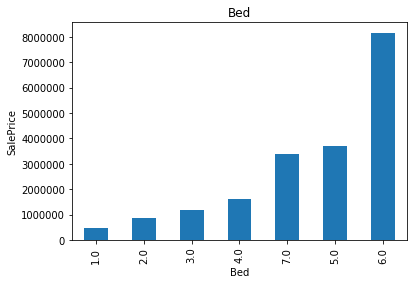

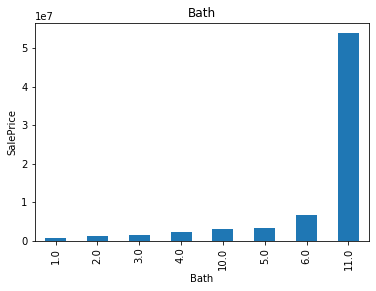

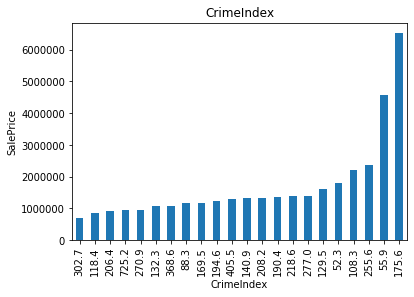

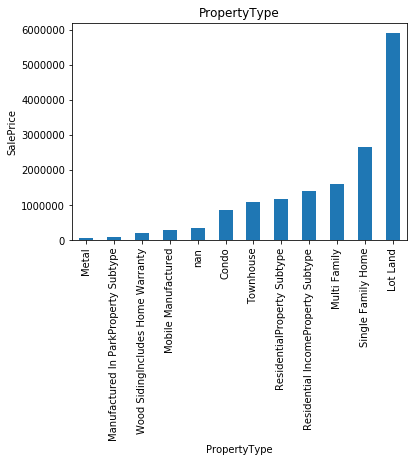

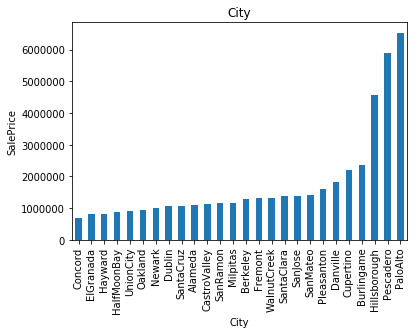

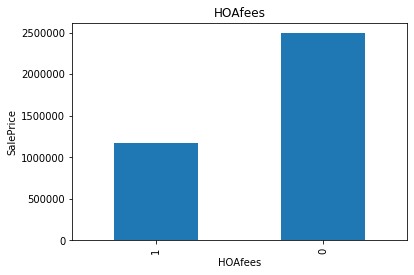

In [678]:
## Lets Find the realtionship between them and Sale PRice
## Handling HOA Category first.
discrete_feature=['Bed','Bath','CrimeIndex','PropertyType','City','HOAfees']
for feature in discrete_feature:
    data=housedf.copy()
    temp=data.groupby(feature)['Price'].mean().sort_values(ascending=True)
    temp.plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    #plt.set_cmap('gist_rainbow')
    plt.show()

##### #Observations:
###### 1.Average Price of Houses having more Beds and Bath are higher than that of Houses having less no of Bed and Baths.
###### 2.Average price of Houses in Cities where CrimeIndex is low is higher than that of Cities where Crime Index is high
###### 3. Houses in Cities like Pescadeo,PaloAlto,Hillsborough are very expensive as compared to cities like ElGranada,HalfMoonBay and Concord
###### 4. Properties of type "Lot Land" are the most expensive ones
###### 5. Houses with no HOA fee are cheaper than the houses with HOA fees.

##### Distribution of Continous Variable

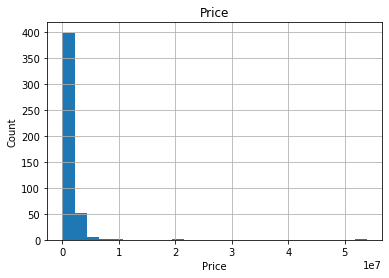

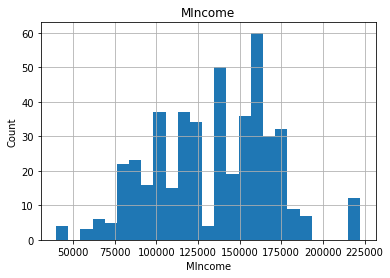

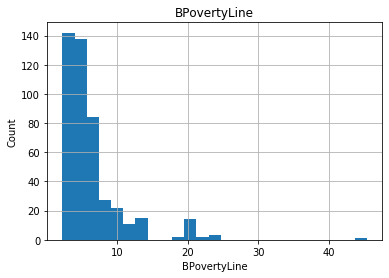

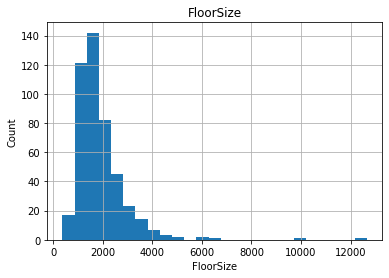

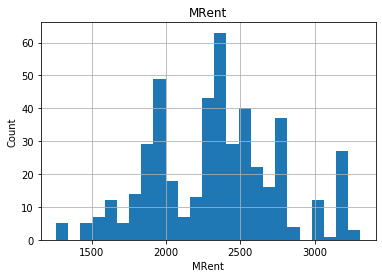

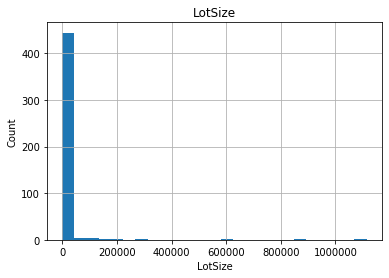

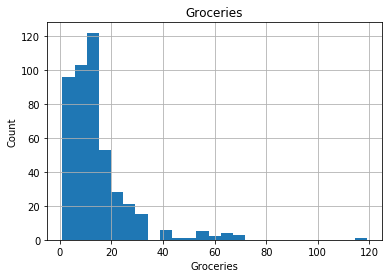

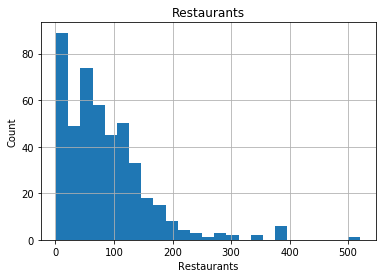

In [688]:
## Lets analyse the continuous values by creating histograms to understand the distribution
numerical_cols=['Price','MIncome','BPovertyLine','FloorSize','MRent','LotSize','Groceries','Restaurants']
for feature in numerical_cols:
    data=housedf.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

###### Observation: Since most of the distribution doesnt follow Normal Distribution ;So We need to take Logarithimic transformation
###### of the corresponding variable

In [ ]:
numerical_cols=['Price','MIncome','BPovertyLine','FloorSize','MRent','LotSize','Groceries','Restaurants']
for feature in numerical_cols:
    data=housedf.copy()
    if 0  in data[feature].unique():
        print(feature)
        pass
    else:
        data[feature]=np.log(data[feature])
        data[feature].hist(bins=25)
        plt.xlabel(feature)
        plt.ylabel("Count")
        plt.title(feature)
    plt.show()

##### Log transformation really helped in acheiving the normal distribution for most of the continous variables

##### Relationship between Price and continous variable

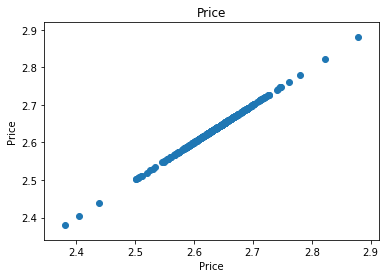

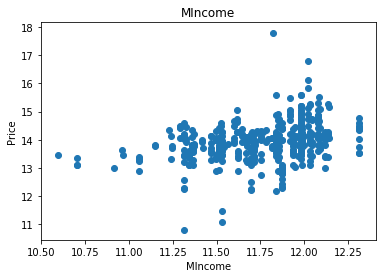

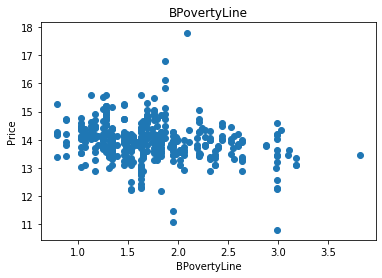

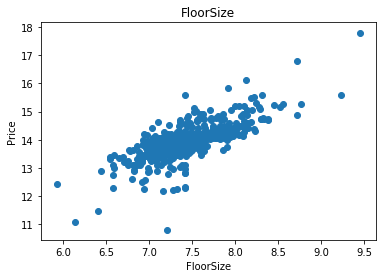

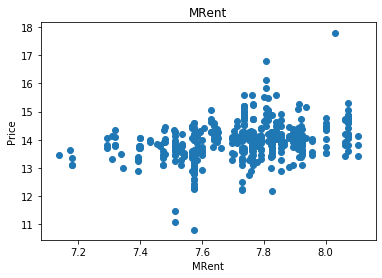

C:\Users\jhash\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


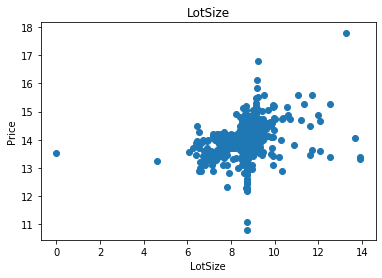

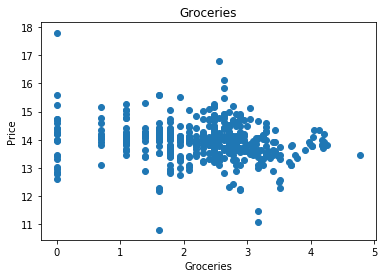

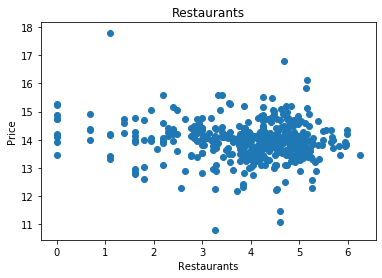

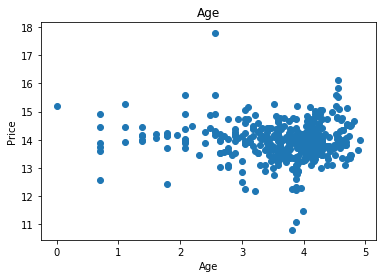

In [679]:
## We will be using logarithmic transformation
numerical_cols=['Price','MIncome','BPovertyLine','FloorSize','MRent','LotSize','Groceries','Restaurants','Age']
for feature in numerical_cols:
    data=housedf.copy()
    data[feature]=np.log(data[feature])
    data['Price']=np.log(data['Price'])
    plt.scatter(data[feature],data['Price'])
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.title(feature)
    plt.show()

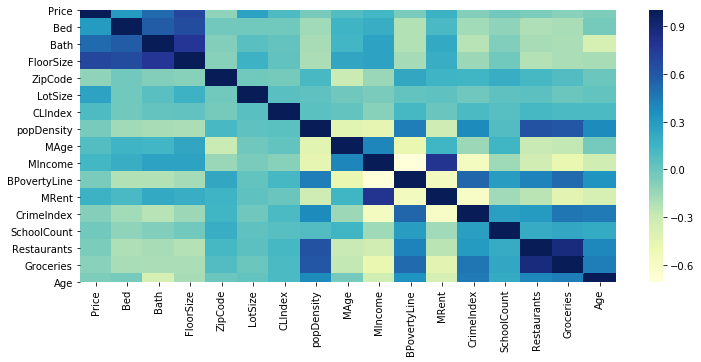

In [683]:
#Creating the Correlation plot
corr_matrix = housedf.corr()
f, ax1 = plt.subplots(figsize=(12,5)) 
ax1=sns.heatmap(corr_matrix,cmap="YlGnBu")

###### Observations:
###### 1.There is a positive correlation between FLoor Size and Price. Similar kind of association could be visible between LotSize and Price.
###### 2. We could see that some houses with large lot Size are really expensive.

#### Checking Outliers

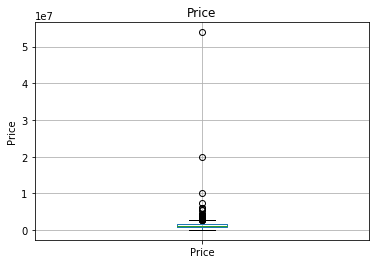

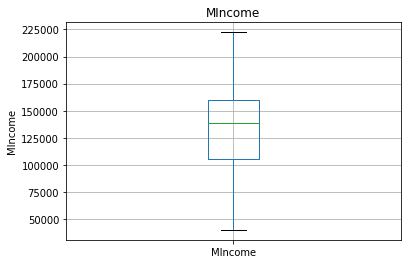

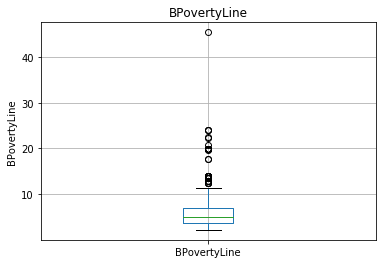

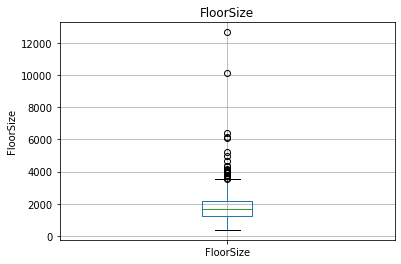

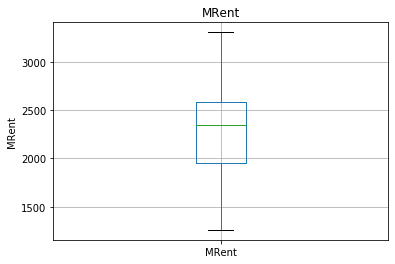

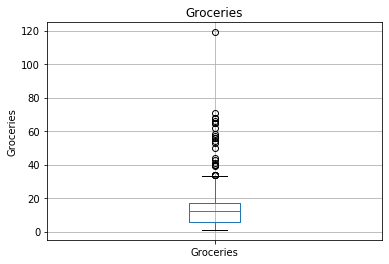

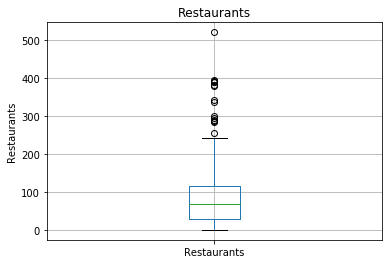

In [684]:
for feature in numerical_cols:
    data=housedf.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

##### Observations: 1> We can see there are lot of Outliers for Price ,Floor Size,No of restaurants,No of Groceries attributes.
###### But We wont be deleting any values as these values come from a genuine source.

## Interesting Relationship between HomePrice and Age

Text(0.5, 1.0, 'House Price vs YearSold')

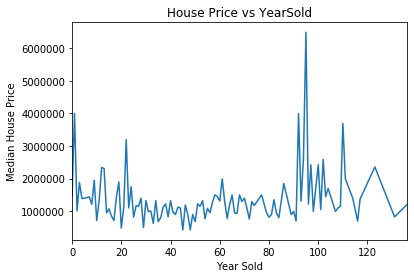

In [685]:
## Relationhip Between Age and House
housedf.groupby('Age')['Price'].median().plot()
plt.xlabel('Year Sold')
plt.ylabel('Median House Price')
plt.title("House Price vs YearSold")

####  We could see two peaks here. One with ages between 0 1nd 10 and other peal between 80-95 yrs old.

In [686]:
#Creating a new variable and categorizing House as New,Old,Middle Aged 
def checkHouseCondition(val):
    val=int(val)
    if(val>=0 and val<=28):
        return "NEW"
    elif(val>=70 and val<=136):
        return "OLD"
    else:
        return "MIDDLE AGED"
housedf['AgeCategory']=housedf['Age'].apply(lambda x:checkHouseCondition(x))  

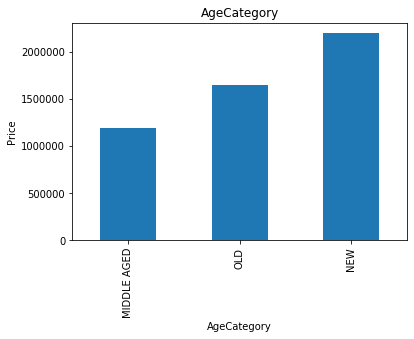

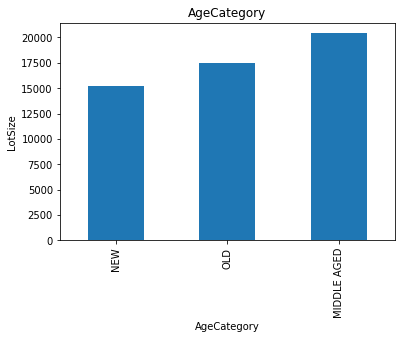

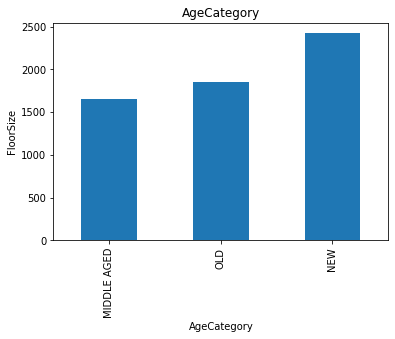

In [687]:
#Checking The average price for all the above categories
for feature in ['Price','LotSize','FloorSize']:
    data=housedf.copy()
    temp=data.groupby('AgeCategory')[feature].mean().sort_values(ascending=True)
    temp.plot.bar()
    plt.xlabel("AgeCategory")
    plt.ylabel(feature)
    plt.title("AgeCategory")
    plt.show()

##### Observations:
###### 1. New Houses have smaller Lot Size as compared to Old Houses
###### 2.New Houses have larger Floor Size
###### 3.New Houses are more expensive than the old houses

##### ................................................................................... DATA ANALYSIS ENDS HERE....................................................................................

#### Creating Dummy variables for Categorical Variables

In [ ]:
#Creating dummies and dropping one of those to prevent multicollinearity
housedf = pd.get_dummies(housedf,columns = ['HOAfees'])
housedf.drop(['HOAfees_1'],axis=1,inplace=True)

In [ ]:
#Writing the clean data to the csv file
housedf.to_csv("HousePriceDetails_Cleaned.csv",index=False)
housedf.head()
